In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
data=pd.read_csv('/content/drive/MyDrive/Stage/CSV-03-11/03-11/data_combined.csv',parse_dates=['Timestamp'])

In [ ]:
# Renommer la colonne pour supprimer les espaces autour de 'Timestamp'
#data.rename(columns=lambda x: x.strip(), inplace=True)

# Convertir la colonne Timestamp en datetime
#data['Timestamp'] = pd.to_datetime(data['Timestamp'], errors='coerce')

# Filtrer les lignes avec des valeurs NaT résultant de la conversion incorrecte
#data = data.dropna(subset=['Timestamp'])

# Ajouter une colonne 'hour_minute_second' en extrayant l'heure, la minute et la seconde (sans la date)
data['hour_minute_second'] = data['Timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')

# Compter le nombre d'attaques par hour_minute_second
hour_minute_second_attacks = data.groupby('hour_minute_second').size().reset_index(name='y')

# Renommer la colonne 'hour_minute_second' en 'ds' pour Prophet
hour_minute_second_attacks.rename(columns={'hour_minute_second': 'ds'}, inplace=True)

# Afficher les premières lignes pour vérifier
print(hour_minute_second_attacks.head(len(hour_minute_second_attacks)))

# Mise à jour du dataframe principal
data = hour_minute_second_attacks

                        ds  y
0      2018-11-03 09:18:16  1
1      2018-11-03 09:18:18  8
2      2018-11-03 09:18:19  1
3      2018-11-03 09:18:20  3
4      2018-11-03 09:18:26  6
...                    ... ..
12219  2018-11-03 17:36:22  2
12220  2018-11-03 17:36:28  1
12221  2018-11-03 17:36:29  1
12222  2018-11-03 17:36:33  1
12223  2018-11-03 17:36:41  1

[12224 rows x 2 columns]


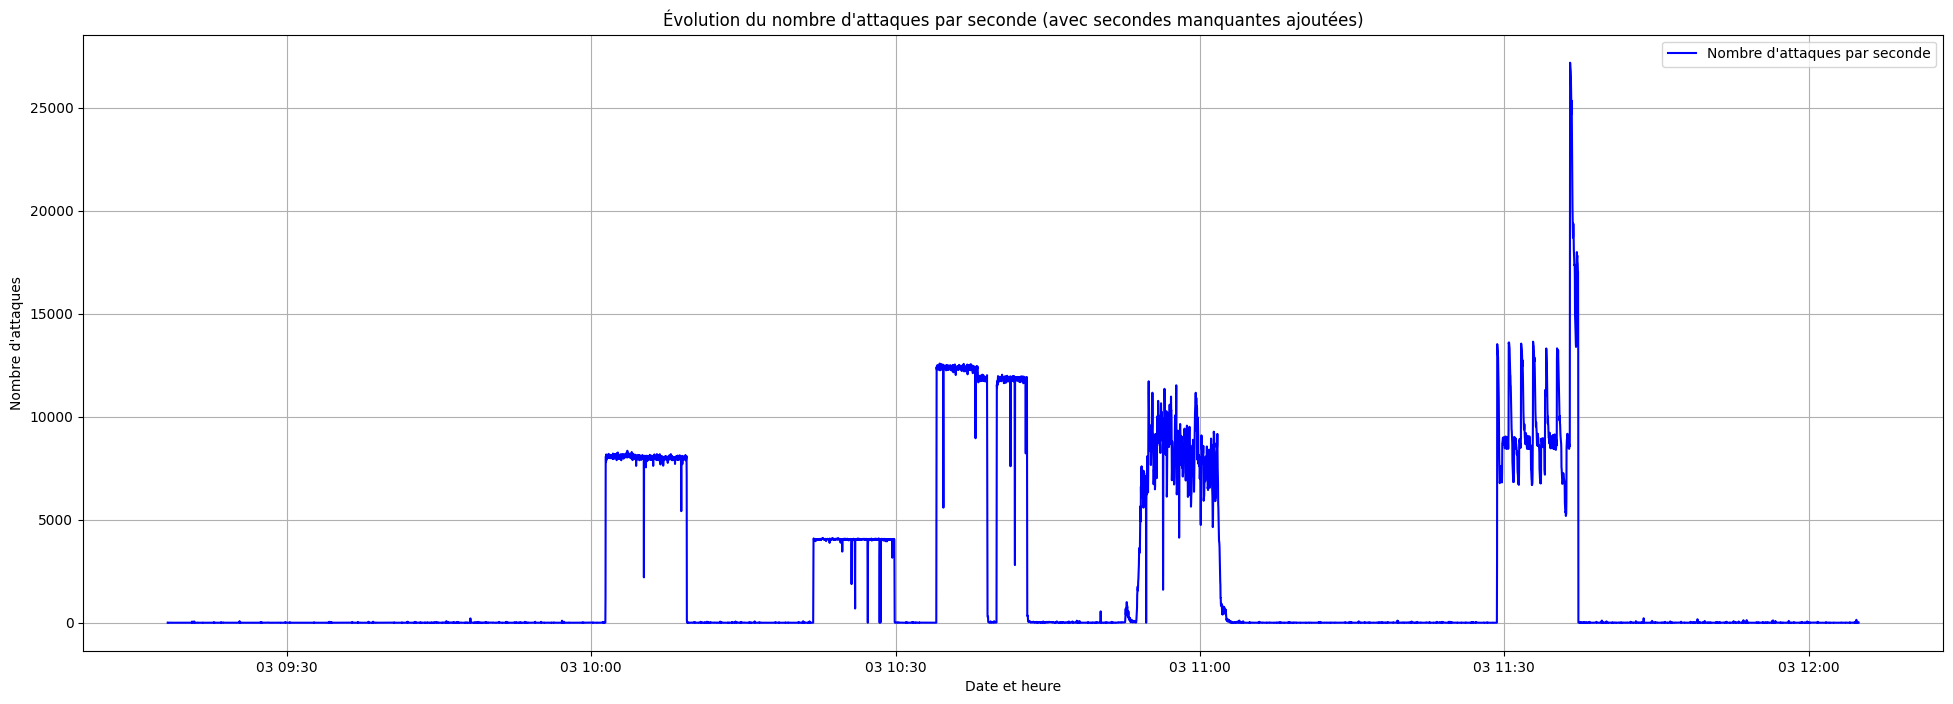

In [ ]:

# Convertir la colonne de dates en datetime si nécessaire
data['ds'] = pd.to_datetime(data['ds'])

# Déterminer la première et la dernière timestamp dans vos données existantes
start_time = data['ds'].min()
end_time = data['ds'].max()

# Générer une séquence de toutes les secondes entre le début et la fin
all_seconds = pd.date_range(start=start_time, end=end_time, freq='S')

# Créer un DataFrame avec toutes les secondes et fusionner avec vos données existantes
all_data = pd.DataFrame({'ds': all_seconds})

# Convertir la colonne de dates en datetime
all_data['ds'] = pd.to_datetime(all_data['ds'])

# Fusionner les données
merged_data = pd.merge(all_data, data, on='ds', how='left')

# Remplacer les NaN par 0 si vous voulez marquer les secondes sans attaque comme 0
merged_data['y'] = merged_data['y'].fillna(0)

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(24, 8))
plt.plot(merged_data['ds'][0:10000], merged_data['y'][0:10000], linestyle='-', color='b', label='Nombre d\'attaques par seconde')
plt.title('Évolution du nombre d\'attaques par seconde (avec secondes manquantes ajoutées)')
plt.xlabel('Date et heure')
plt.ylabel('Nombre d\'attaques')
plt.grid(True)
plt.legend()
plt.show()

# LSTM short and long terme prediction

## avec dropout avec et une seule couche LSTM

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score

# Supposons que 'data' est déjà un DataFrame contenant les colonnes 'ds' et 'y'
df = merged_data[0:10000].copy()

# Convertir les dates en format datetime
df['ds'] = pd.to_datetime(df['ds'])

# Normaliser les données
scaler = MinMaxScaler()
df['y'] = scaler.fit_transform(df[['y']])

# Créer des séquences temporelles
def create_sequences(data, seq_length, long_term_offset):
    X = []
    y_short_term = []
    y_long_term = []
    for i in range(len(data) - seq_length - long_term_offset):
        X.append(data[i:i+seq_length])
        y_short_term.append(data[i+seq_length])
        y_long_term.append(data[i+seq_length + long_term_offset])
    return np.array(X), np.array(y_short_term), np.array(y_long_term)

seq_length = 20
long_term_offset = 20  # Ajustez cela selon vos besoins
X, y_short_term, y_long_term = create_sequences(df['y'].values, seq_length, long_term_offset)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train_short, y_test_short, y_train_long, y_test_long = train_test_split(
    X, y_short_term, y_long_term, test_size=0.4, shuffle=False)

# Reshape les données pour LSTM (samples, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Définir le modèle LSTM avec deux sorties
def create_lstm_model(seq_length, feature_count):
    inputs = Input(shape=(seq_length, feature_count))

    # Première couche LSTM
    x = LSTM(units=50, return_sequences=False)(inputs)
    x = Dropout(0.2)(x)

    # Prédiction à court terme
    short_term_output = Dense(units=1, name='short_term_output')(x)

    # Prédiction à long terme
    long_term_output = Dense(units=1, name='long_term_output')(x)

    # Création du modèle
    model = Model(inputs=inputs, outputs=[short_term_output, long_term_output])

    # Compilation du modèle
    model.compile(optimizer=Adam(), loss='mean_squared_error')

    return model

# Exemple d'utilisation
feature_count = 1  # nombre de caractéristiques (une seule caractéristique pour les séries temporelles simples)
model = create_lstm_model(seq_length, feature_count)

# Affichage de la structure du modèle
model.summary()

# Entraînement du modèle
history = model.fit(
    X_train,
    {'short_term_output': y_train_short, 'long_term_output': y_train_long},
    epochs=10, batch_size=1, verbose=2,
    validation_data=(X_test, {'short_term_output': y_test_short, 'long_term_output': y_test_long})
)

# Faire des prédictions
train_predictions_short, train_predictions_long = model.predict(X_train)
test_predictions_short, test_predictions_long = model.predict(X_test)

# Inverser la normalisation
train_predictions_short = scaler.inverse_transform(train_predictions_short)
test_predictions_short = scaler.inverse_transform(test_predictions_short)
train_predictions_long = scaler.inverse_transform(train_predictions_long)
test_predictions_long = scaler.inverse_transform(test_predictions_long)

y_train_true_short = scaler.inverse_transform(y_train_short.reshape(-1, 1))
y_test_true_short = scaler.inverse_transform(y_test_short.reshape(-1, 1))
y_train_true_long = scaler.inverse_transform(y_train_long.reshape(-1, 1))
y_test_true_long = scaler.inverse_transform(y_test_long.reshape(-1, 1))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 20, 1)]              0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 50)                   10400     ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 50)                   0         ['lstm[0][0]']                
                                                                                                  
 short_term_output (Dense)   (None, 1)                    51        ['dropout[0][0]']             
                                                                                              

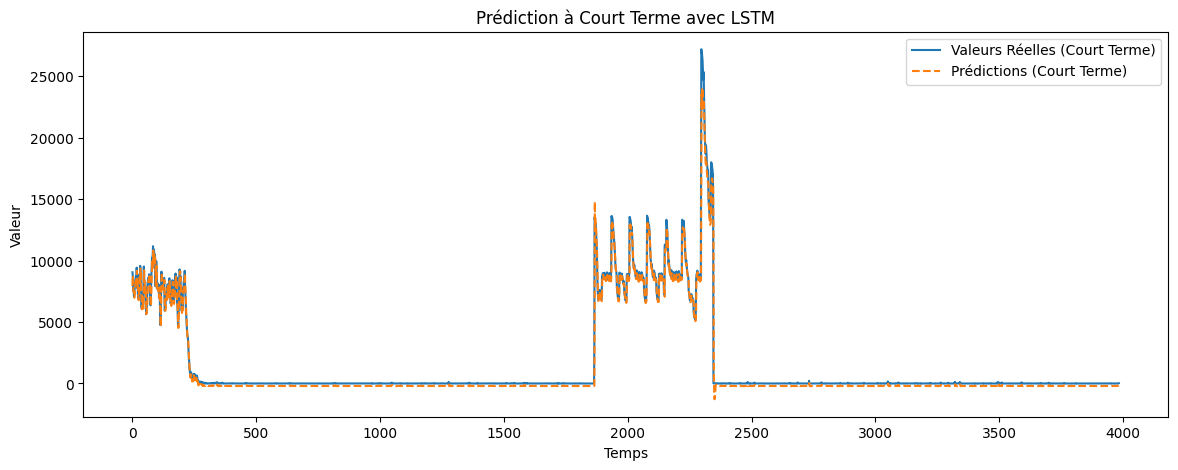

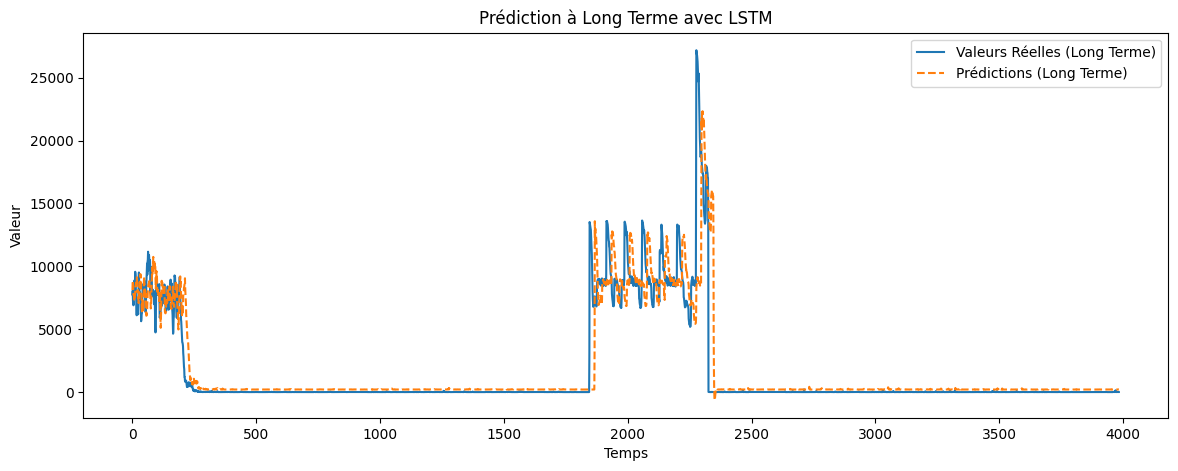

In [ ]:
# Visualisation des résultats
plt.figure(figsize=(14, 5))
plt.plot(y_test_true_short,  label='Valeurs Réelles (Court Terme)')
plt.plot(test_predictions_short,  label='Prédictions (Court Terme)',linestyle='--')
plt.title('Prédiction à Court Terme avec LSTM')
plt.xlabel('Temps')
plt.ylabel('Valeur')
plt.legend()
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(y_test_true_long, label='Valeurs Réelles (Long Terme)')
plt.plot(test_predictions_long, label='Prédictions (Long Terme)',linestyle='--')
plt.title('Prédiction à Long Terme avec LSTM')
plt.xlabel('Temps')
plt.ylabel('Valeur')
plt.legend()
plt.show()

In [ ]:
# Calcul de l'erreur quadratique moyenne
mse = mean_squared_error(y_test_true_short, test_predictions_short)
print(f'Mean Squared Error: {mse}')

# Calcul du R²
r2 = r2_score(y_test_true_short, test_predictions_short)

print(f'R Square: {r2}')

Mean Squared Error: 256752.62755076133
R Square: 0.982682601933359


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
# Calcul de l'erreur quadratique moyenne
mse = mean_squared_error(y_test_true_long, test_predictions_long)
print(f'Mean Squared Error: {mse}')

# Calcul du R²
r2 = r2_score(y_test_true_long, test_predictions_long)

print(f'R Square: {r2}')

Mean Squared Error: 4027886.4651625445
R Square: 0.7246058769822428


## avec dropout avec et deux couche LSTM

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score

# Supposons que 'data' est déjà un DataFrame contenant les colonnes 'ds' et 'y'
df = merged_data[0:10000].copy()

# Convertir les dates en format datetime
df['ds'] = pd.to_datetime(df['ds'])

# Normaliser les données
scaler = MinMaxScaler()
df['y'] = scaler.fit_transform(df[['y']])

# Créer des séquences temporelles
def create_sequences(data, seq_length, long_term_offset):
    X = []
    y_short_term = []
    y_long_term = []
    for i in range(len(data) - seq_length - long_term_offset):
        X.append(data[i:i+seq_length])
        y_short_term.append(data[i+seq_length])
        y_long_term.append(data[i+seq_length + long_term_offset])
    return np.array(X), np.array(y_short_term), np.array(y_long_term)

seq_length = 20
long_term_offset = 20  # Ajustez cela selon vos besoins
X, y_short_term, y_long_term = create_sequences(df['y'].values, seq_length, long_term_offset)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train_short, y_test_short, y_train_long, y_test_long = train_test_split(
    X, y_short_term, y_long_term, test_size=0.4, shuffle=False)

# Reshape les données pour LSTM (samples, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Définir le modèle LSTM avec deux sorties
def create_lstm_model(seq_length, feature_count):
    inputs = Input(shape=(seq_length, feature_count))

    # Première couche LSTM
    x = LSTM(units=50, return_sequences=True)(inputs)
    x = Dropout(0.2)(x)

    # Deuxième couche LSTM
    x = LSTM(units=50, return_sequences=False)(x)
    x = Dropout(0.2)(x)

    # Prédiction à court terme
    short_term_output = Dense(units=1, name='short_term_output')(x)

    # Prédiction à long terme
    long_term_output = Dense(units=1, name='long_term_output')(x)

    # Création du modèle
    model = Model(inputs=inputs, outputs=[short_term_output, long_term_output])

    # Compilation du modèle
    model.compile(optimizer=Adam(), loss='mean_squared_error')

    return model

# Exemple d'utilisation
feature_count = 1  # nombre de caractéristiques (une seule caractéristique pour les séries temporelles simples)
model = create_lstm_model(seq_length, feature_count)

# Affichage de la structure du modèle
model.summary()

# Entraînement du modèle
history = model.fit(
    X_train,
    {'short_term_output': y_train_short, 'long_term_output': y_train_long},
    epochs=10, batch_size=1, verbose=2,
    validation_data=(X_test, {'short_term_output': y_test_short, 'long_term_output': y_test_long})
)

# Faire des prédictions
train_predictions_short, train_predictions_long = model.predict(X_train)
test_predictions_short, test_predictions_long = model.predict(X_test)

# Inverser la normalisation
train_predictions_short = scaler.inverse_transform(train_predictions_short)
test_predictions_short = scaler.inverse_transform(test_predictions_short)
train_predictions_long = scaler.inverse_transform(train_predictions_long)
test_predictions_long = scaler.inverse_transform(test_predictions_long)

y_train_true_short = scaler.inverse_transform(y_train_short.reshape(-1, 1))
y_test_true_short = scaler.inverse_transform(y_test_short.reshape(-1, 1))
y_train_true_long = scaler.inverse_transform(y_train_long.reshape(-1, 1))
y_test_true_long = scaler.inverse_transform(y_test_long.reshape(-1, 1))


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 20, 1)]              0         []                            
                                                                                                  
 lstm_1 (LSTM)               (None, 20, 50)               10400     ['input_2[0][0]']             
                                                                                                  
 dropout_1 (Dropout)         (None, 20, 50)               0         ['lstm_1[0][0]']              
                                                                                                  
 lstm_2 (LSTM)               (None, 50)                   20200     ['dropout_1[0][0]']           
                                                                                            

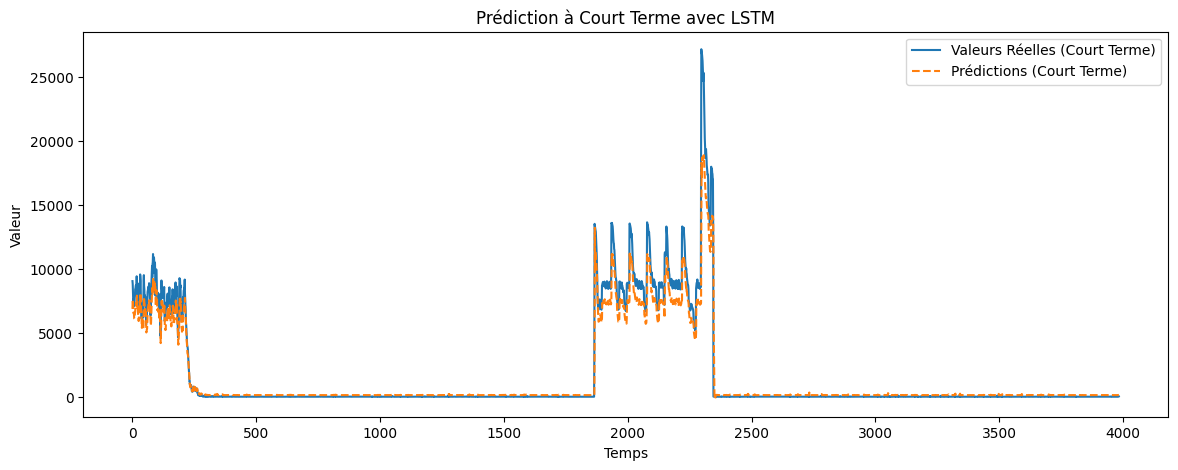

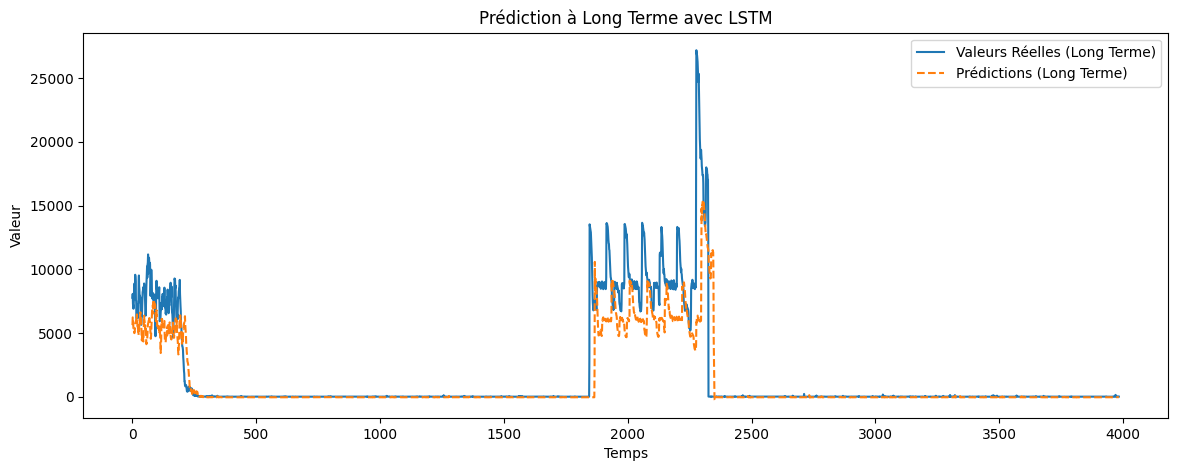

In [ ]:
# Visualisation des résultats
plt.figure(figsize=(14, 5))
plt.plot(y_test_true_short,  label='Valeurs Réelles (Court Terme)')
plt.plot(test_predictions_short,  label='Prédictions (Court Terme)',linestyle='--')
plt.title('Prédiction à Court Terme avec LSTM')
plt.xlabel('Temps')
plt.ylabel('Valeur')
plt.legend()
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(y_test_true_long, label='Valeurs Réelles (Long Terme)')
plt.plot(test_predictions_long, label='Prédictions (Long Terme)',linestyle='--')
plt.title('Prédiction à Long Terme avec LSTM')
plt.xlabel('Temps')
plt.ylabel('Valeur')
plt.legend()
plt.show()

In [ ]:
# Calcul de l'erreur quadratique moyenne
mse = mean_squared_error(y_test_true_short, test_predictions_short)
print(f'Mean Squared Error: {mse}')

# Calcul du R²
r2 = r2_score(y_test_true_short, test_predictions_short)

print(f'R Square: {r2}')

Mean Squared Error: 728321.9293993955
R Square: 0.9508762932929292


In [ ]:

# Calcul de l'erreur quadratique moyenne
mse = mean_squared_error(y_test_true_long, test_predictions_long)
print(f'Mean Squared Error: {mse}')

# Calcul du R²
r2 = r2_score(y_test_true_long, test_predictions_long)

print(f'R Square: {r2}')

Mean Squared Error: 4652790.184705745
R Square: 0.681880042154823


# 10s

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score

# Supposons que 'data' est déjà un DataFrame contenant les colonnes 'ds' et 'y'
df = merged_data[0:10000].copy()

# Convertir les dates en format datetime
df['ds'] = pd.to_datetime(df['ds'])

# Normaliser les données
scaler = MinMaxScaler()
df['y'] = scaler.fit_transform(df[['y']])

# Créer des séquences temporelles
def create_sequences(data, seq_length, long_term_offset):
    X = []
    y_short_term = []
    y_long_term = []
    for i in range(len(data) - seq_length - long_term_offset):
        X.append(data[i:i+seq_length])
        y_short_term.append(data[i+seq_length])
        y_long_term.append(data[i+seq_length + long_term_offset])
    return np.array(X), np.array(y_short_term), np.array(y_long_term)

seq_length = 20
long_term_offset = 10  # Ajustez cela selon vos besoins
X, y_short_term, y_long_term = create_sequences(df['y'].values, seq_length, long_term_offset)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train_short, y_test_short, y_train_long, y_test_long = train_test_split(
    X, y_short_term, y_long_term, test_size=0.4, shuffle=False)

# Reshape les données pour LSTM (samples, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Définir le modèle LSTM avec deux sorties
def create_lstm_model(seq_length, feature_count):
    inputs = Input(shape=(seq_length, feature_count))

    # Première couche LSTM
    x = LSTM(units=50, return_sequences=False)(inputs)
    x = Dropout(0.2)(x)

    # Prédiction à court terme
    short_term_output = Dense(units=1, name='short_term_output')(x)

    # Prédiction à long terme
    long_term_output = Dense(units=1, name='long_term_output')(x)

    # Création du modèle
    model = Model(inputs=inputs, outputs=[short_term_output, long_term_output])

    # Compilation du modèle
    model.compile(optimizer=Adam(), loss='mean_squared_error')

    return model

# Exemple d'utilisation
feature_count = 1  # nombre de caractéristiques (une seule caractéristique pour les séries temporelles simples)
model = create_lstm_model(seq_length, feature_count)

# Affichage de la structure du modèle
model.summary()

# Entraînement du modèle
history = model.fit(
    X_train,
    {'short_term_output': y_train_short, 'long_term_output': y_train_long},
    epochs=10, batch_size=1, verbose=2,
    validation_data=(X_test, {'short_term_output': y_test_short, 'long_term_output': y_test_long})
)

# Faire des prédictions
train_predictions_short, train_predictions_long = model.predict(X_train)
test_predictions_short, test_predictions_long = model.predict(X_test)

# Inverser la normalisation
train_predictions_short = scaler.inverse_transform(train_predictions_short)
test_predictions_short = scaler.inverse_transform(test_predictions_short)
train_predictions_long = scaler.inverse_transform(train_predictions_long)
test_predictions_long = scaler.inverse_transform(test_predictions_long)

y_train_true_short = scaler.inverse_transform(y_train_short.reshape(-1, 1))
y_test_true_short = scaler.inverse_transform(y_test_short.reshape(-1, 1))
y_train_true_long = scaler.inverse_transform(y_train_long.reshape(-1, 1))
y_test_true_long = scaler.inverse_transform(y_test_long.reshape(-1, 1))

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 20, 1)]              0         []                            
                                                                                                  
 lstm_3 (LSTM)               (None, 50)                   10400     ['input_3[0][0]']             
                                                                                                  
 dropout_3 (Dropout)         (None, 50)                   0         ['lstm_3[0][0]']              
                                                                                                  
 short_term_output (Dense)   (None, 1)                    51        ['dropout_3[0][0]']           
                                                                                            

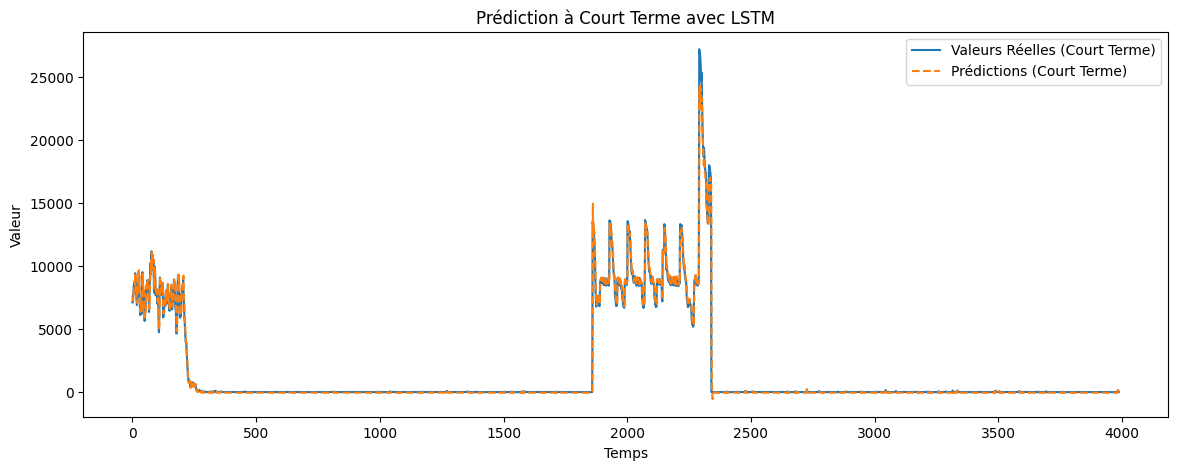

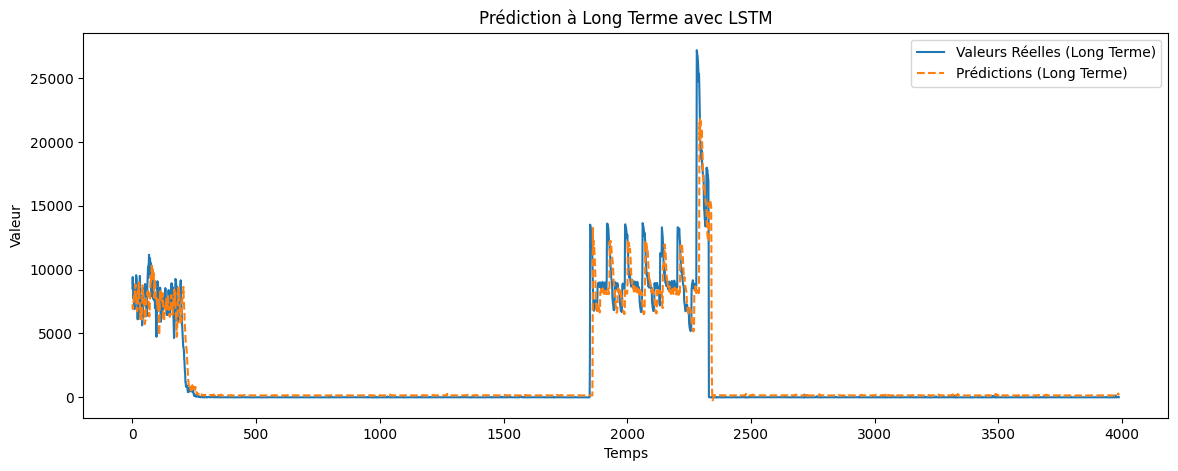

In [ ]:
# Visualisation des résultats
plt.figure(figsize=(14, 5))
plt.plot(y_test_true_short,  label='Valeurs Réelles (Court Terme)')
plt.plot(test_predictions_short,  label='Prédictions (Court Terme)',linestyle='--')
plt.title('Prédiction à Court Terme avec LSTM')
plt.xlabel('Temps')
plt.ylabel('Valeur')
plt.legend()
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(y_test_true_long, label='Valeurs Réelles (Long Terme)')
plt.plot(test_predictions_long, label='Prédictions (Long Terme)',linestyle='--')
plt.title('Prédiction à Long Terme avec LSTM')
plt.xlabel('Temps')
plt.ylabel('Valeur')
plt.legend()
plt.show()

In [ ]:
# Calcul de l'erreur quadratique moyenne
mse = mean_squared_error(y_test_true_short, test_predictions_short)
print(f'Mean Squared Error: {mse}')

# Calcul du R²
r2 = r2_score(y_test_true_short, test_predictions_short)

print(f'R Square: {r2}')

Mean Squared Error: 208065.09192370126
R Square: 0.9858988331330374


In [ ]:

# Calcul de l'erreur quadratique moyenne
mse = mean_squared_error(y_test_true_long, test_predictions_long)
print(f'Mean Squared Error: {mse}')

# Calcul du R²
r2 = r2_score(y_test_true_long, test_predictions_long)

print(f'R Square: {r2}')

Mean Squared Error: 2696607.0884157615
R Square: 0.8160686094639809


# 15S

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score

# Supposons que 'data' est déjà un DataFrame contenant les colonnes 'ds' et 'y'
df = merged_data[0:10000].copy()

# Convertir les dates en format datetime
df['ds'] = pd.to_datetime(df['ds'])

# Normaliser les données
scaler = MinMaxScaler()
df['y'] = scaler.fit_transform(df[['y']])

# Créer des séquences temporelles
def create_sequences(data, seq_length, long_term_offset):
    X = []
    y_short_term = []
    y_long_term = []
    for i in range(len(data) - seq_length - long_term_offset):
        X.append(data[i:i+seq_length])
        y_short_term.append(data[i+seq_length])
        y_long_term.append(data[i+seq_length + long_term_offset])
    return np.array(X), np.array(y_short_term), np.array(y_long_term)

seq_length = 20
long_term_offset = 10  # Ajustez cela selon vos besoins
X, y_short_term, y_long_term = create_sequences(df['y'].values, seq_length, long_term_offset)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train_short, y_test_short, y_train_long, y_test_long = train_test_split(
    X, y_short_term, y_long_term, test_size=0.4, shuffle=False)

# Reshape les données pour LSTM (samples, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Définir le modèle LSTM avec deux sorties
def create_lstm_model(seq_length, feature_count):
    inputs = Input(shape=(seq_length, feature_count))

    # Première couche LSTM
    x = LSTM(units=50, return_sequences=False)(inputs)
    x = Dropout(0.2)(x)

    # Prédiction à court terme
    short_term_output = Dense(units=1, name='short_term_output')(x)

    # Prédiction à long terme
    long_term_output = Dense(units=1, name='long_term_output')(x)

    # Création du modèle
    model = Model(inputs=inputs, outputs=[short_term_output, long_term_output])

    # Compilation du modèle
    model.compile(optimizer=Adam(), loss='mean_squared_error')

    return model

# Exemple d'utilisation
feature_count = 1  # nombre de caractéristiques (une seule caractéristique pour les séries temporelles simples)
model = create_lstm_model(seq_length, feature_count)

# Affichage de la structure du modèle
model.summary()

# Entraînement du modèle
history = model.fit(
    X_train,
    {'short_term_output': y_train_short, 'long_term_output': y_train_long},
    epochs=10, batch_size=1, verbose=2,
    validation_data=(X_test, {'short_term_output': y_test_short, 'long_term_output': y_test_long})
)

# Faire des prédictions
train_predictions_short, train_predictions_long = model.predict(X_train)
test_predictions_short, test_predictions_long = model.predict(X_test)

# Inverser la normalisation
train_predictions_short = scaler.inverse_transform(train_predictions_short)
test_predictions_short = scaler.inverse_transform(test_predictions_short)
train_predictions_long = scaler.inverse_transform(train_predictions_long)
test_predictions_long = scaler.inverse_transform(test_predictions_long)

y_train_true_short = scaler.inverse_transform(y_train_short.reshape(-1, 1))
y_test_true_short = scaler.inverse_transform(y_test_short.reshape(-1, 1))
y_train_true_long = scaler.inverse_transform(y_train_long.reshape(-1, 1))
y_test_true_long = scaler.inverse_transform(y_test_long.reshape(-1, 1))

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 20, 1)]              0         []                            
                                                                                                  
 lstm_4 (LSTM)               (None, 50)                   10400     ['input_4[0][0]']             
                                                                                                  
 dropout_4 (Dropout)         (None, 50)                   0         ['lstm_4[0][0]']              
                                                                                                  
 short_term_output (Dense)   (None, 1)                    51        ['dropout_4[0][0]']           
                                                                                            

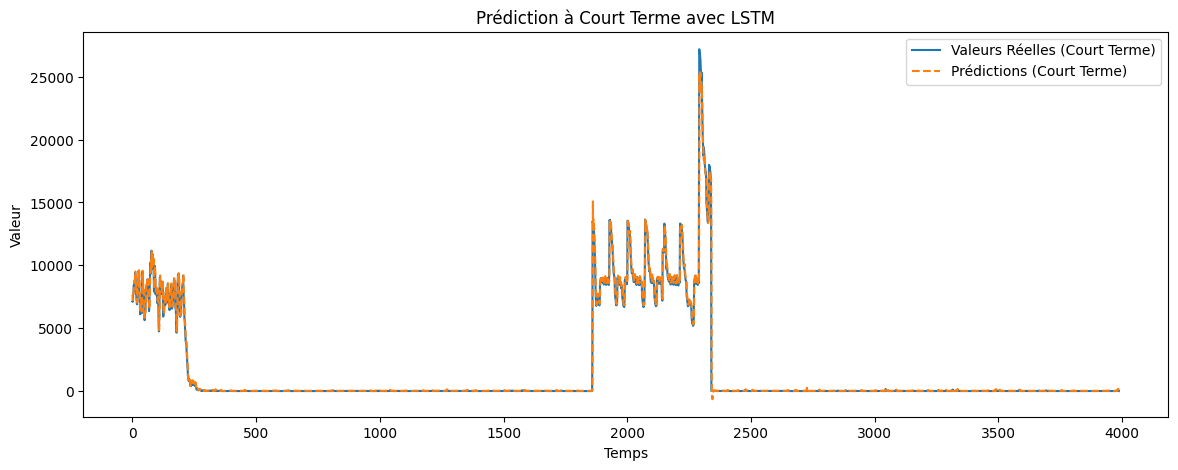

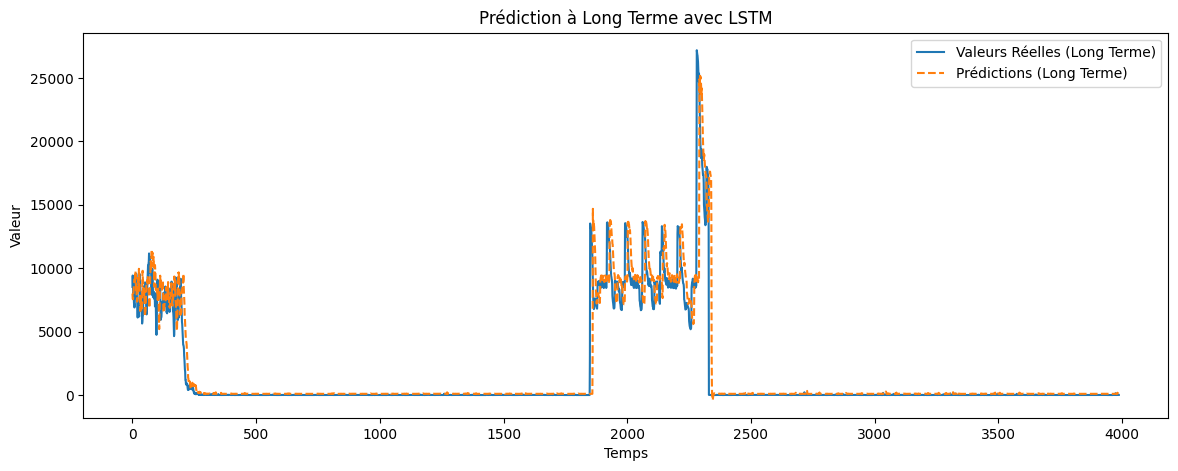

In [ ]:
# Visualisation des résultats
plt.figure(figsize=(14, 5))
plt.plot(y_test_true_short,  label='Valeurs Réelles (Court Terme)')
plt.plot(test_predictions_short,  label='Prédictions (Court Terme)',linestyle='--')
plt.title('Prédiction à Court Terme avec LSTM')
plt.xlabel('Temps')
plt.ylabel('Valeur')
plt.legend()
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(y_test_true_long, label='Valeurs Réelles (Long Terme)')
plt.plot(test_predictions_long, label='Prédictions (Long Terme)',linestyle='--')
plt.title('Prédiction à Long Terme avec LSTM')
plt.xlabel('Temps')
plt.ylabel('Valeur')
plt.legend()
plt.show()

In [ ]:
# Calcul de l'erreur quadratique moyenne
mse = mean_squared_error(y_test_true_short, test_predictions_short)
print(f'Mean Squared Error: {mse}')

# Calcul du R²
r2 = r2_score(y_test_true_short, test_predictions_short)

print(f'R Square: {r2}')

Mean Squared Error: 193327.5534554179
R Square: 0.9868976383013054


In [ ]:

# Calcul de l'erreur quadratique moyenne
mse = mean_squared_error(y_test_true_long, test_predictions_long)
print(f'Mean Squared Error: {mse}')

# Calcul du R²
r2 = r2_score(y_test_true_long, test_predictions_long)

print(f'R Square: {r2}')

Mean Squared Error: 2980174.970361201
R Square: 0.7967268836850797


# 5s

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score

# Supposons que 'data' est déjà un DataFrame contenant les colonnes 'ds' et 'y'
df = merged_data[0:10000].copy()

# Convertir les dates en format datetime
df['ds'] = pd.to_datetime(df['ds'])

# Normaliser les données
scaler = MinMaxScaler()
df['y'] = scaler.fit_transform(df[['y']])

# Créer des séquences temporelles
def create_sequences(data, seq_length, long_term_offset):
    X = []
    y_short_term = []
    y_long_term = []
    for i in range(len(data) - seq_length - long_term_offset):
        X.append(data[i:i+seq_length])
        y_short_term.append(data[i+seq_length])
        y_long_term.append(data[i+seq_length + long_term_offset])
    return np.array(X), np.array(y_short_term), np.array(y_long_term)

seq_length = 20
long_term_offset = 5  # Ajustez cela selon vos besoins
X, y_short_term, y_long_term = create_sequences(df['y'].values, seq_length, long_term_offset)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train_short, y_test_short, y_train_long, y_test_long = train_test_split(
    X, y_short_term, y_long_term, test_size=0.4, shuffle=False)

# Reshape les données pour LSTM (samples, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Définir le modèle LSTM avec deux sorties
def create_lstm_model(seq_length, feature_count):
    inputs = Input(shape=(seq_length, feature_count))

    # Première couche LSTM
    x = LSTM(units=50, return_sequences=False)(inputs)
    x = Dropout(0.2)(x)

    # Prédiction à court terme
    short_term_output = Dense(units=1, name='short_term_output')(x)

    # Prédiction à long terme
    long_term_output = Dense(units=1, name='long_term_output')(x)

    # Création du modèle
    model = Model(inputs=inputs, outputs=[short_term_output, long_term_output])

    # Compilation du modèle
    model.compile(optimizer=Adam(), loss='mean_squared_error')

    return model

# Exemple d'utilisation
feature_count = 1  # nombre de caractéristiques (une seule caractéristique pour les séries temporelles simples)
model = create_lstm_model(seq_length, feature_count)

# Affichage de la structure du modèle
model.summary()

# Entraînement du modèle
history = model.fit(
    X_train,
    {'short_term_output': y_train_short, 'long_term_output': y_train_long},
    epochs=10, batch_size=1, verbose=2,
    validation_data=(X_test, {'short_term_output': y_test_short, 'long_term_output': y_test_long})
)

# Faire des prédictions
train_predictions_short, train_predictions_long = model.predict(X_train)
test_predictions_short, test_predictions_long = model.predict(X_test)

# Inverser la normalisation
train_predictions_short = scaler.inverse_transform(train_predictions_short)
test_predictions_short = scaler.inverse_transform(test_predictions_short)
train_predictions_long = scaler.inverse_transform(train_predictions_long)
test_predictions_long = scaler.inverse_transform(test_predictions_long)

y_train_true_short = scaler.inverse_transform(y_train_short.reshape(-1, 1))
y_test_true_short = scaler.inverse_transform(y_test_short.reshape(-1, 1))
y_train_true_long = scaler.inverse_transform(y_train_long.reshape(-1, 1))
y_test_true_long = scaler.inverse_transform(y_test_long.reshape(-1, 1))

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 20, 1)]              0         []                            
                                                                                                  
 lstm_5 (LSTM)               (None, 50)                   10400     ['input_5[0][0]']             
                                                                                                  
 dropout_5 (Dropout)         (None, 50)                   0         ['lstm_5[0][0]']              
                                                                                                  
 short_term_output (Dense)   (None, 1)                    51        ['dropout_5[0][0]']           
                                                                                            

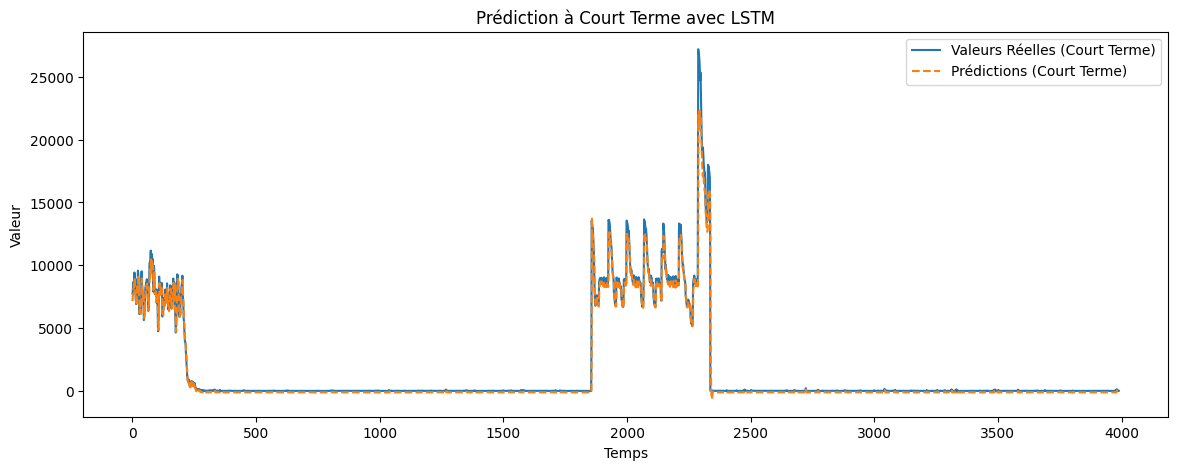

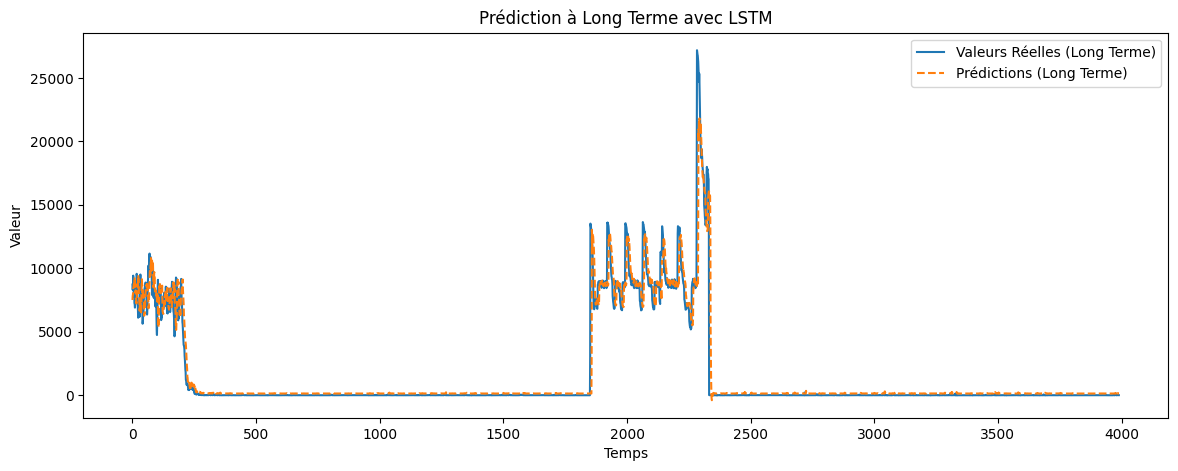

In [ ]:
# Visualisation des résultats
plt.figure(figsize=(14, 5))
plt.plot(y_test_true_short,  label='Valeurs Réelles (Court Terme)')
plt.plot(test_predictions_short,  label='Prédictions (Court Terme)',linestyle='--')
plt.title('Prédiction à Court Terme avec LSTM')
plt.xlabel('Temps')
plt.ylabel('Valeur')
plt.legend()
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(y_test_true_long, label='Valeurs Réelles (Long Terme)')
plt.plot(test_predictions_long, label='Prédictions (Long Terme)',linestyle='--')
plt.title('Prédiction à Long Terme avec LSTM')
plt.xlabel('Temps')
plt.ylabel('Valeur')
plt.legend()
plt.show()

In [ ]:
# Calcul de l'erreur quadratique moyenne
mse = mean_squared_error(y_test_true_short, test_predictions_short)
print(f'Mean Squared Error: {mse}')

# Calcul du R²
r2 = r2_score(y_test_true_short, test_predictions_short)

print(f'R Square: {r2}')

Mean Squared Error: 282258.17728767527
R Square: 0.980835564750714


In [ ]:

# Calcul de l'erreur quadratique moyenne
mse = mean_squared_error(y_test_true_long, test_predictions_long)
print(f'Mean Squared Error: {mse}')

# Calcul du R²
r2 = r2_score(y_test_true_long, test_predictions_long)

print(f'R Square: {r2}')

Mean Squared Error: 1621719.9192088265
R Square: 0.8895084679287946


# 2S

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score

# Supposons que 'data' est déjà un DataFrame contenant les colonnes 'ds' et 'y'
df = merged_data[0:10000].copy()

# Convertir les dates en format datetime
df['ds'] = pd.to_datetime(df['ds'])

# Normaliser les données
scaler = MinMaxScaler()
df['y'] = scaler.fit_transform(df[['y']])

# Créer des séquences temporelles
def create_sequences(data, seq_length, long_term_offset):
    X = []
    y_short_term = []
    y_long_term = []
    for i in range(len(data) - seq_length - long_term_offset):
        X.append(data[i:i+seq_length])
        y_short_term.append(data[i+seq_length])
        y_long_term.append(data[i+seq_length + long_term_offset])
    return np.array(X), np.array(y_short_term), np.array(y_long_term)

seq_length = 20
long_term_offset = 2  # Ajustez cela selon vos besoins
X, y_short_term, y_long_term = create_sequences(df['y'].values, seq_length, long_term_offset)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train_short, y_test_short, y_train_long, y_test_long = train_test_split(
    X, y_short_term, y_long_term, test_size=0.4, shuffle=False)

# Reshape les données pour LSTM (samples, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Définir le modèle LSTM avec deux sorties
def create_lstm_model(seq_length, feature_count):
    inputs = Input(shape=(seq_length, feature_count))

    # Première couche LSTM
    x = LSTM(units=50, return_sequences=False)(inputs)
    x = Dropout(0.2)(x)

    # Prédiction à court terme
    short_term_output = Dense(units=1, name='short_term_output')(x)

    # Prédiction à long terme
    long_term_output = Dense(units=1, name='long_term_output')(x)

    # Création du modèle
    model = Model(inputs=inputs, outputs=[short_term_output, long_term_output])

    # Compilation du modèle
    model.compile(optimizer=Adam(), loss='mean_squared_error')

    return model

# Exemple d'utilisation
feature_count = 1  # nombre de caractéristiques (une seule caractéristique pour les séries temporelles simples)
model = create_lstm_model(seq_length, feature_count)

# Affichage de la structure du modèle
model.summary()

# Entraînement du modèle
history = model.fit(
    X_train,
    {'short_term_output': y_train_short, 'long_term_output': y_train_long},
    epochs=10, batch_size=1, verbose=2,
    validation_data=(X_test, {'short_term_output': y_test_short, 'long_term_output': y_test_long})
)

# Faire des prédictions
train_predictions_short, train_predictions_long = model.predict(X_train)
test_predictions_short, test_predictions_long = model.predict(X_test)

# Inverser la normalisation
train_predictions_short = scaler.inverse_transform(train_predictions_short)
test_predictions_short = scaler.inverse_transform(test_predictions_short)
train_predictions_long = scaler.inverse_transform(train_predictions_long)
test_predictions_long = scaler.inverse_transform(test_predictions_long)

y_train_true_short = scaler.inverse_transform(y_train_short.reshape(-1, 1))
y_test_true_short = scaler.inverse_transform(y_test_short.reshape(-1, 1))
y_train_true_long = scaler.inverse_transform(y_train_long.reshape(-1, 1))
y_test_true_long = scaler.inverse_transform(y_test_long.reshape(-1, 1))

NameError: name 'merged_data' is not defined

In [ ]:
# Visualisation des résultats
plt.figure(figsize=(14, 5))
plt.plot(y_test_true_short,  label='Valeurs Réelles (Court Terme)')
plt.plot(test_predictions_short,  label='Prédictions (Court Terme)',linestyle='--')
plt.title('Prédiction à Court Terme avec LSTM')
plt.xlabel('Temps')
plt.ylabel('Valeur')
plt.legend()
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(y_test_true_long, label='Valeurs Réelles (Long Terme)')
plt.plot(test_predictions_long, label='Prédictions (Long Terme)',linestyle='--')
plt.title('Prédiction à Long Terme avec LSTM')
plt.xlabel('Temps')
plt.ylabel('Valeur')
plt.legend()
plt.show()

In [ ]:
# Calcul de l'erreur quadratique moyenne
mse = mean_squared_error(y_test_true_short, test_predictions_short)
print(f'Mean Squared Error: {mse}')

# Calcul du R²
r2 = r2_score(y_test_true_short, test_predictions_short)

print(f'R Square: {r2}')

In [ ]:

# Calcul de l'erreur quadratique moyenne
mse = mean_squared_error(y_test_true_long, test_predictions_long)
print(f'Mean Squared Error: {mse}')

# Calcul du R²
r2 = r2_score(y_test_true_long, test_predictions_long)

print(f'R Square: {r2}')

# 3s

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, r2_score

# Supposons que 'data' est déjà un DataFrame contenant les colonnes 'ds' et 'y'
df = merged_data[0:10000].copy()

# Convertir les dates en format datetime
df['ds'] = pd.to_datetime(df['ds'])

# Normaliser les données
scaler = MinMaxScaler()
df['y'] = scaler.fit_transform(df[['y']])

# Créer des séquences temporelles
def create_sequences(data, seq_length, long_term_offset):
    X = []
    y_short_term = []
    y_long_term = []
    for i in range(len(data) - seq_length - long_term_offset):
        X.append(data[i:i+seq_length])
        y_short_term.append(data[i+seq_length])
        y_long_term.append(data[i+seq_length + long_term_offset])
    return np.array(X), np.array(y_short_term), np.array(y_long_term)

seq_length = 20
long_term_offset = 2  # Ajustez cela selon vos besoins
X, y_short_term, y_long_term = create_sequences(df['y'].values, seq_length, long_term_offset)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train_short, y_test_short, y_train_long, y_test_long = train_test_split(
    X, y_short_term, y_long_term, test_size=0.4, shuffle=False)

# Reshape les données pour LSTM (samples, timesteps, features)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Définir le modèle LSTM avec deux sorties
def create_lstm_model(seq_length, feature_count):
    inputs = Input(shape=(seq_length, feature_count))

    # Première couche LSTM
    x = LSTM(units=50, return_sequences=False)(inputs)
    x = Dropout(0.2)(x)

    # Prédiction à court terme
    short_term_output = Dense(units=1, name='short_term_output')(x)

    # Prédiction à long terme
    long_term_output = Dense(units=1, name='long_term_output')(x)

    # Création du modèle
    model = Model(inputs=inputs, outputs=[short_term_output, long_term_output])

    # Compilation du modèle
    model.compile(optimizer=Adam(), loss='mean_squared_error')

    return model

# Exemple d'utilisation
feature_count = 1  # nombre de caractéristiques (une seule caractéristique pour les séries temporelles simples)
model = create_lstm_model(seq_length, feature_count)

# Affichage de la structure du modèle
model.summary()

# Entraînement du modèle
history = model.fit(
    X_train,
    {'short_term_output': y_train_short, 'long_term_output': y_train_long},
    epochs=10, batch_size=1, verbose=2,
    validation_data=(X_test, {'short_term_output': y_test_short, 'long_term_output': y_test_long})
)

# Faire des prédictions
train_predictions_short, train_predictions_long = model.predict(X_train)
test_predictions_short, test_predictions_long = model.predict(X_test)

# Inverser la normalisation
train_predictions_short = scaler.inverse_transform(train_predictions_short)
test_predictions_short = scaler.inverse_transform(test_predictions_short)
train_predictions_long = scaler.inverse_transform(train_predictions_long)
test_predictions_long = scaler.inverse_transform(test_predictions_long)

y_train_true_short = scaler.inverse_transform(y_train_short.reshape(-1, 1))
y_test_true_short = scaler.inverse_transform(y_test_short.reshape(-1, 1))
y_train_true_long = scaler.inverse_transform(y_train_long.reshape(-1, 1))
y_test_true_long = scaler.inverse_transform(y_test_long.reshape(-1, 1))